# Wetlands Insight Tool -DEWLP- WetMAP_polygons_18Jul19_16/09/2019

### import modules


In [90]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from textwrap import wrap

from datacube.storage import masking
from datacube.utils import geometry
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='wetlands insight tool')

global Output_dir
Output_dir = '/g/data/r78/rjd547/DEWLP-Vic_Project/WIT/WITv3/'

### Set up polygon

### change the path here if you want a different polygon

In [2]:
poly_path = '/g/data/r78/rjd547/DEWLP-Vic_Project/WetMAP_newest/WetMAP_polygons_18Jul19.shp'

In [83]:
def get_WetMAP_newest(feature):
    'function just for the WetMAP_newest polygons'
    if feature['properties']['NAME_MAIN']is not None:
        polyName = '_'.join(feature['properties']['NAME_MAIN'].split(' ')).replace("'","_").replace("/","_") 
    else:     
        print("your shapefile names don t work")
    print(f'processing polygon {polyName}')
    return(polyName)

In [84]:
with fiona.open(poly_path) as shapes:
    print(next(iter(shapes))['properties'])
    print(next(iter(shapes))['properties'])
    get_WetMAP_newest(next(iter(shapes)))

OrderedDict([('WETLAND_NO', 45267), ('NAME_MAIN', 'Reedy Lagoon (Gunbower Forest)'), ('WETLAND_TY', 'Temporary freshwater marshes and meadows'), ('AQ_SYS', 'Palustrine'), ('AQ_SYS_CON', 'Moderate'), ('SAL_REGIME', 'Fresh'), ('SAL_REG_CO', 'Moderate'), ('WTRREG', 'Periodically Inundated - Seasonal Or Intermittent'), ('WTRREG_CON', 'Moderate'), ('SRC_TIDE', 'Non-tidal'), ('SRC_TIDE_C', 'High'), ('SRC_RVR', 'Very high'), ('SRC_RVR_CO', 'High'), ('SRC_GW', 'Low'), ('SRC_GW_CON', 'Moderate'), ('SRC_ART', 'Artificial'), ('SRC_ART_CO', 'High'), ('DOM_VEG', 'Sedge/grass/forb'), ('DOM_VEG_CO', 'High'), ('HECTARES', 41.07), ('Wetland_Co', 'RELG'), ('CMA_1', 'NCCMA'), ('Latitude', -35.726506), ('Longitude', 144.20738)])
OrderedDict([('WETLAND_NO', 45267), ('NAME_MAIN', 'Reedy Lagoon (Gunbower Forest)'), ('WETLAND_TY', 'Temporary freshwater marshes and meadows'), ('AQ_SYS', 'Palustrine'), ('AQ_SYS_CON', 'Moderate'), ('SAL_REGIME', 'Fresh'), ('SAL_REG_CO', 'Moderate'), ('WTRREG', 'Periodically Inun

In [85]:
#open the polygon and manually select your favourite polygon the lazy way
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)
        feature_of_interest_geometry = first_geometry
        geom = geometry.Geometry(feature_of_interest_geometry, crs=crs)
        polyName = get_WetMAP_newest(next(iter(shapes)))

processing polygon Reedy_Lagoon_(Gunbower_Forest)


In [7]:
def get_masked_ls578_data(query, geom):
    '''create a function that takes in the masked proportion, query and geometry and returns the fully masked surface reflectance data'''
    ## Set up datasets
    #set cloudmasking threshold and load landsat nbart data
    landsat_masked_prop = 0.90
    ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
            masked_prop=landsat_masked_prop)

    ### mask the data with our original polygon to remove extra data 

    data = ls578_ds
    mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                               out_shape=data.geobox.shape,
                                               transform=data.geobox.affine,
                                               all_touched=False,
                                               invert=False)

    #for some reason xarray is not playing nicely with our old masking function
    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    ls578_ds = data.where(mask_xr==False)
    return ls578_ds, mask_xr

In [8]:
def get_masked_tcw(sr_data, mask, threshold=-350):
    '''uses TasseledCapTools and an input threshold (defaults to -350) to create masked over-threshold tasseled cap '''

    #transform the nbart into tci
    tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

    #select only finite values (over threshold values)
    tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

    # #reapply the polygon mask
    tcw = tcw.where(mask_xr==False)

    return tcw

### Set up query

In [9]:
query = {'geopolygon': geom,
         #'time': ('1991-01-01', '1994-01-01')
         }

### Load data sets, where 90% of data is unmasked

#### Landsat data

In [10]:
#load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME
ls578_ds, mask_xr= get_masked_ls578_data(query,geom)

Loading ls5
    Loading 429 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 87 filtered ls7 timesteps
Loading ls8
    Loading 163 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [11]:
#calculate tasselled cap wetness within masked AOI
tcw = get_masked_tcw(ls578_ds, mask_xr, threshold=-350)

In [12]:
#wofls = dc.load(product = 'wofs_albers', like=ls578_ds, fuse_func=wofs_fuser)
wofls = dc.load(product = 'wofs_albers',fuse_func=wofs_fuser, **query)

#first, match tcw and wofs

In [13]:
wofls = wofls.where(wofls.time==tcw.time)

In [14]:
# #reapply the polygon mask
wofls = wofls.where(mask_xr==False)

In [15]:
wet_wofs = wofls.where(wofls.water==128)

In [16]:
shadow_wofs = wofls.where(wofls.water== 136) #use bit values for wet (128) and terrain/low-angle (8)

In [17]:
sea_wofs = wofls.where(wofls.water==132) #bit values for wet (128) and sea (4)
sea_shadow_wofs = wofls.where(wofls.water==140)# bit values for wet (128) and sea (4) and terrain/low-angle (8)

## load in fractional cover data

In [18]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5
    Loading 429 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 87 filtered ls7 timesteps
Loading ls8
    Loading 163 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask FC with polygon

In [19]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [20]:
fc_ds_noTCW=fc_ds.where(tcw==False)
#match timesteps
fc_ds_noTCW= fc_ds_noTCW.where(fc_ds_noTCW.time==tcw.time)

### Calculate the dominant fraction for each pixel in Fractional Cover

In [21]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

### Calculate number of pixels in area of interest

In [22]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [23]:
#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

In [24]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [25]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [26]:
#count number of wofs pixels
wofs_pixels = (wet_wofs.water.count(dim=['x','y'])+shadow_wofs.water.count(dim=['x','y']) +
sea_wofs.water.count(dim=['x','y'])+sea_shadow_wofs.water.count(dim=['x','y']))

In [27]:
#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100
#wofs_area_percent

In [28]:
#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

In [29]:
#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

In [30]:
#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

In [31]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

In [32]:
#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

In [33]:
#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

In [34]:
#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

In [35]:
#work out where we have actual values!
FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

In [36]:
#restack the Fractional cover dataset all together
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [37]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [38]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon
#Work out the number of nodata pixels in the data, so that we can graph the variables by number of observed pixels.

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

In [39]:
NoDataPixels = (NoData/100) * pixels 

In [40]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent2=(FC_count.BS/(pixels - NoDataPixels))*100

Photosynthetic_veg_percent2=(FC_count.PV/(pixels- NoDataPixels))*100

NonPhotosynthetic_veg_percent2=(FC_count.NPV/(pixels- NoDataPixels))*100

In [41]:
#count percentage of area of wofs
wofs_area_percent2 = (wofs_pixels/(pixels - NoDataPixels))*100
#wofs_area_percent

In [42]:
#count number of tcw pixels
tcw_pixel_count2 = tcw.sum(dim=['x','y'])

In [43]:
#calculate percentage area wet
tcw_area_percent2 = (tcw_pixel_count2/(pixels - NoDataPixels))*100

In [44]:
#calculate wet not wofs
tcw_less_wofs2 = tcw_area_percent2-wofs_area_percent2

In [45]:
#last check for timestep matching before we plot
wofs_area_percent2=wofs_area_percent2.where(wofs_area_percent2.time==Bare_soil_percent2.time)
Bare_soil_percent2=Bare_soil_percent2.where(Bare_soil_percent2.time==wofs_area_percent2.time)
Photosynthetic_veg_percent2=Photosynthetic_veg_percent2.where(Photosynthetic_veg_percent2.time==wofs_area_percent2.time)
NonPhotosynthetic_veg_percent2=NonPhotosynthetic_veg_percent2.where(NonPhotosynthetic_veg_percent2.time==wofs_area_percent2.time)

<Figure size 432x288 with 0 Axes>

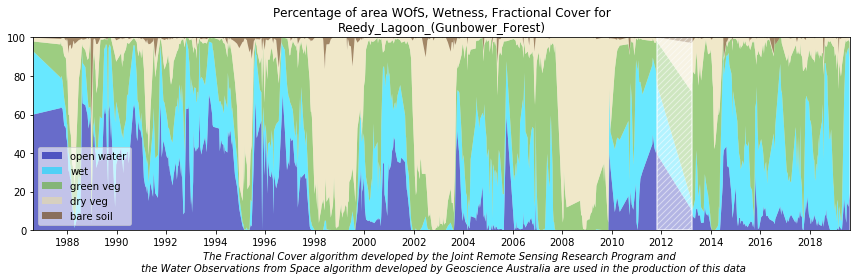

plot created for Reedy_Lagoon_(Gunbower_Forest)


In [92]:
#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

#make a stacked area plot
plt.clf()
fig= plt.figure(figsize = (12,4))
plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent2, 
              tcw_less_wofs2, 
              Photosynthetic_veg_percent2, 
              NonPhotosynthetic_veg_percent2,
              Bare_soil_percent2,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)

#set axis limits to the min and max
plt.axis(xmin = wofs_area_percent2.time[0].data, xmax = wofs_area_percent2.time[-1].data, ymin = 0, ymax = 100)

#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6)
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)
gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start

#set date ticks every year
years = mdates.YearLocator(2)
yearsFmt = mdates.DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#ax.yaxis.set_ticks(np.arange(0,110,10))
ax.set_xlabel(f'The Fractional Cover algorithm developed by the Joint Remote'
f' Sensing Research Program and \n the Water Observations from Space algorithm '
f'developed by Geoscience Australia are used in the production of this data',style='italic')

#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax.add_patch(slc_rectangle)

polyName=polyName.replace("'","\\'")
title=ax.set_title("\n".join(wrap(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')))
fig.tight_layout()
title.set_y(1.05)

#save the figure
plt.savefig(f'{Output_dir}{polyName}.png')
plt.show()
print(f'plot created for {polyName}')

In [91]:
#make a new dataframe using the data from the xarray of wofs area for the polygon

### start setup of dataframe by adding only one dataset
WOFS_df = pd.DataFrame(data=wofs_area_percent2.data, index=wofs_area_percent2.time.values,columns=['wofs_area_percent'])

#add data into pandas dataframe for export
WOFS_df['wet_percent']=tcw_less_wofs2.data
WOFS_df['green_veg_percent']=Photosynthetic_veg_percent2.data
WOFS_df['dry_veg_percent']=NonPhotosynthetic_veg_percent2.data
WOFS_df['bare_soil_percent']=Bare_soil_percent2.data

#call the composite dataframe something sensible, like PolyDrill
PolyDrill_df = WOFS_df.round(2)

#save the csv of the output data used to create the stacked plot for the polygon drill
PolyDrill_df.to_csv(f'{Output_dir}{polyName}.csv')
print(f'wrote output data to file {Output_dir}{polyName}.csv')

wrote output data to file /g/data/r78/rjd547/DEWLP-Vic_Project/WIT/WITv3/Reedy_Lagoon_(Gunbower_Forest).csv
